## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import os

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0


## Misc Utilities

In [2]:
class MAPELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MAPELoss, self).__init__()
        self.eta = 1e-9

    def forward(self, y_pred, y_true):
        l = torch.abs((y_true - y_pred)) / (torch.abs(y_true) + self.eta)

        return torch.mean(l)

class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:87: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


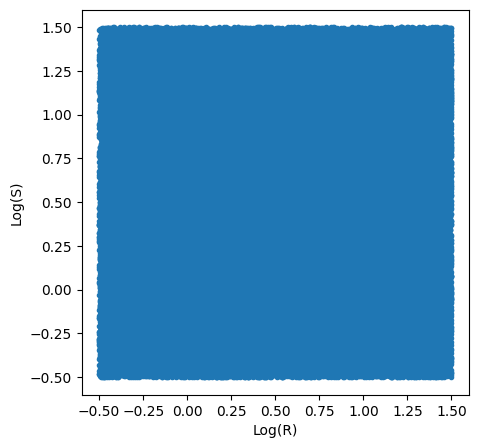

In [3]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 1.5)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


## Network Training

In [4]:
# Defining model parameters
checkpoint_dir = './Model_Checkpoints/'

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 3,
        "h_dim": 20,
        "dropout": 0.01,
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 0.00001,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 100,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        "iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 1,
}

In [5]:
x_scaler = StandardScaler().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train)
y_train = torch.tensor(y_scaled_train)


x_test = torch.tensor(x_scaler.transform(etas_test))
y_test = torch.tensor(y_scaler.transform(gs_test))

In [6]:
test_criteria = RMSELoss()

callbacks = [EarlyStopping(patience=15, threshold=0.0001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
        Checkpoint(monitor='valid_loss_best', f_params=f'TurbulenceNetwork_MCD.pt', dirname='./Model_Checkpoints/'),
        LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.0001, threshold_mode='abs', mode='min', verbose=True)
]
train_params['callbacks'] = callbacks


net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
net = net.fit(x_train, y_train)

net.load_params(f_params=checkpoint_dir+f'TurbulenceNetwork_MCD.pt')
test_pred = net.predict(x_test)

print(f"\t\tTest loss: {test_criteria(torch.tensor(test_pred),y_test)}")

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


/home/codygrogan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.6056        0.4248     +  1.5489
      2        0.3435        0.2659     +  1.4269
      3        0.2396        0.2015     +  1.4539
      4        0.1819        0.1579     +  1.3678
      5        0.1453        0.1145     +  1.4226
      6        0.1179        0.1042     +  1.4052
      7        0.0993        0.0791     +  1.4096
      8        0.0827        0.1010        1.3833
      9        0.0729        0.0664     +  1.4002
     10        0.0677        0.0443     +  1.4350
     11        0.0579        0.0546        1.3336
     12        0.0538        0.0509        1.3452
     13        0.0465        0.0332     +  1.4101
     14        0.0437        0.0303     +  1.3463
     15        0.0426        0.0370        1.3912
     16        0.0373        0.0282     +  1.3688
     17        0.0443        0.0418        1.4339
     18        0.0361        0.0235     +  1.3728


Exception ignored in: <function _releaseLock at 0x7fced615b100>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


     20        0.0357        0.0375        1.4080
     21        0.0308        0.0166     +  1.4112
     22        0.0327        0.0429        1.5597
     23        0.0305        0.0197        1.4797
     24        0.0290        0.0480        1.3753
     25        0.0449        0.0394        1.3852
     26        0.0282        0.0210        1.4208
     27        0.0350        0.0147     +  1.4067
     28        0.0319        0.0211        1.4353
     29        0.0286        0.0142     +  1.5114
		Test loss: 0.12191913831785485


In [7]:
test_pred = y_scaler.inverse_transform(net.predict(x_test))

test_loss = MAPELoss()(torch.tensor(test_pred), torch.tensor(gs_test))

print(f"Test loss: {test_loss}")

Test loss: 0.532819019353148


## Reinitializing Trained Model

In [8]:
checkpoint_dir = './Model_Checkpoints'

net = reinitialize_model('TurbulenceNetwork_MCD.pt', checkpoint_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


## Generating Statistics Data

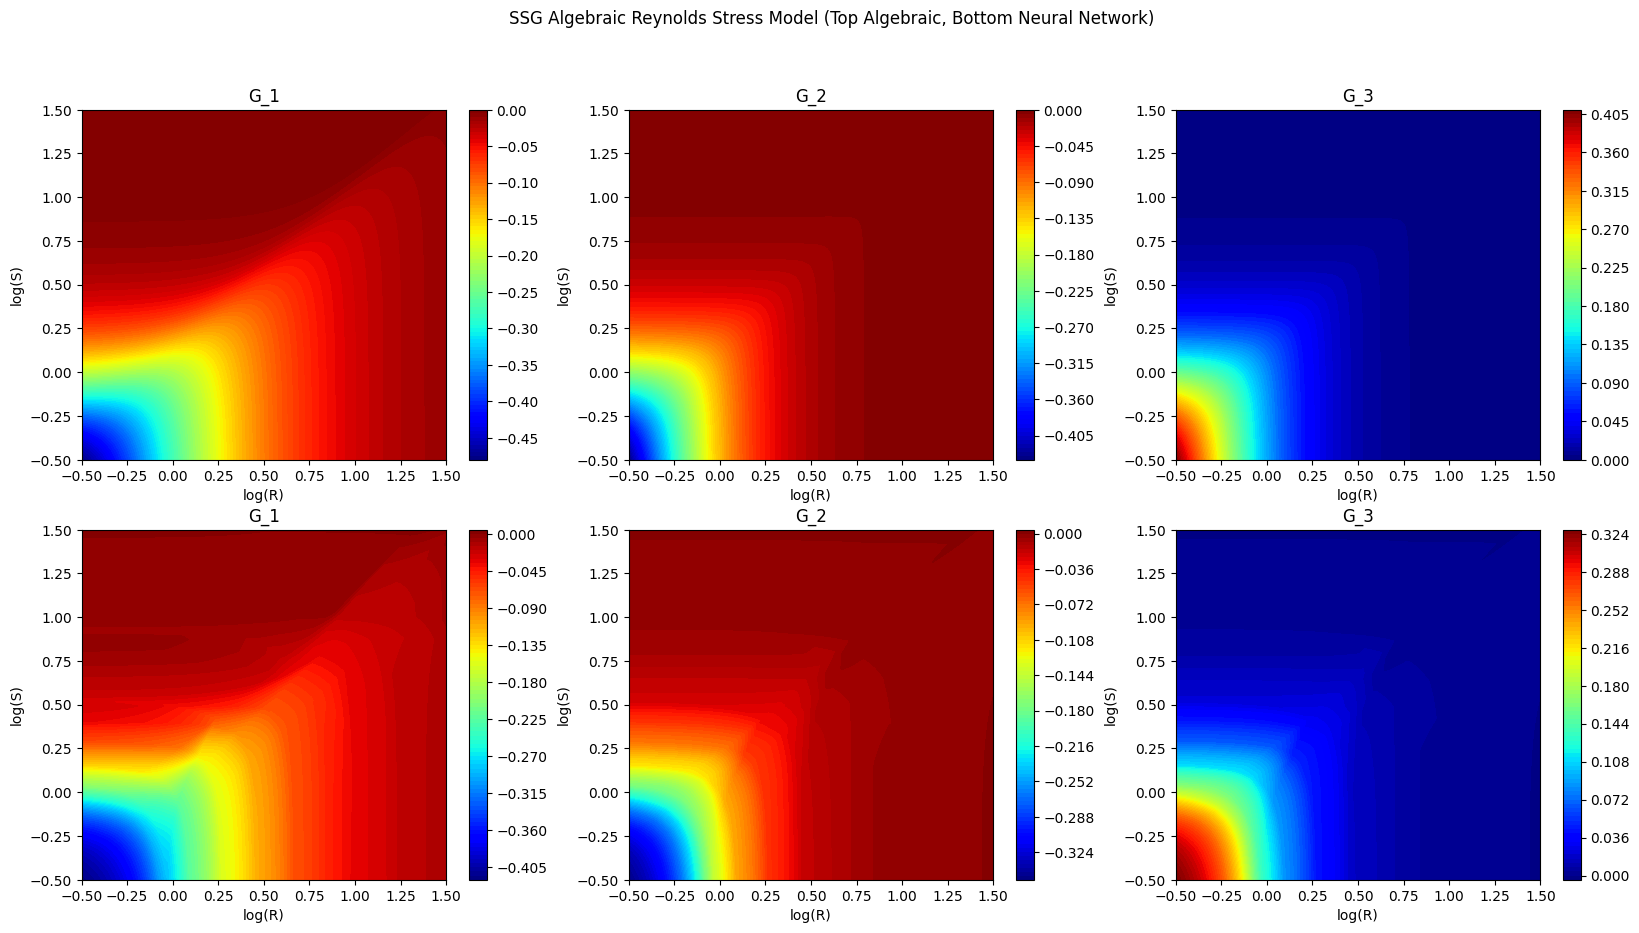

In [9]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

pred = net.predict(etas)

pred = y_scaler.inverse_transform(pred)


pred = pred.T.reshape(3, dim, dim)


plot_heat_map_compare(x_grid, y_grid, target, pred)


## Generating Model Uncertainty From Dropout

In [10]:
T = 50
predictions = np.zeros((T, dim*dim, 3))

batch_size = dim*dim // 2


net.module.dropout_on(net_params['dropout'])

for i in range(T):
    batches = np.zeros((len(etas)//batch_size, batch_size , 3))
    for j in range(len(etas)//batch_size):
        batches[j] = net.module(torch.tensor(etas[j*batch_size:(j+1)*batch_size]).to(device)).cpu().detach()
    print(i)
    predictions[i] = y_scaler.inverse_transform(batches.reshape(dim*dim, 3))
    del batches
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [11]:
mean_pred = np.mean(predictions, axis=0)

variance_pred = np.std(predictions, axis=0)

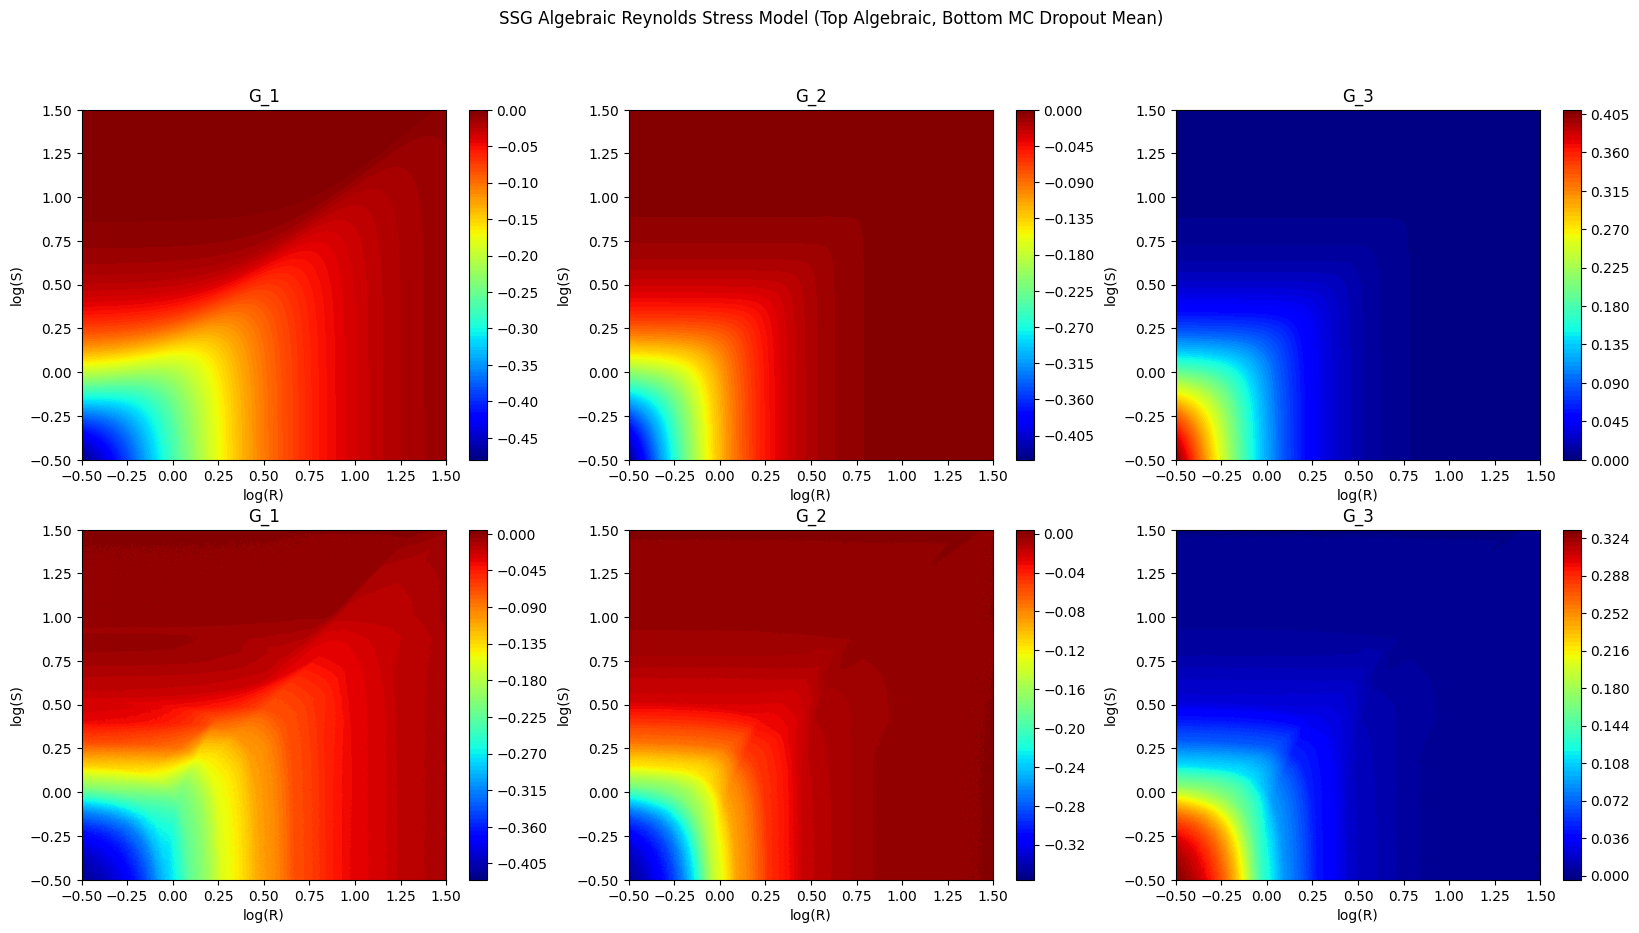

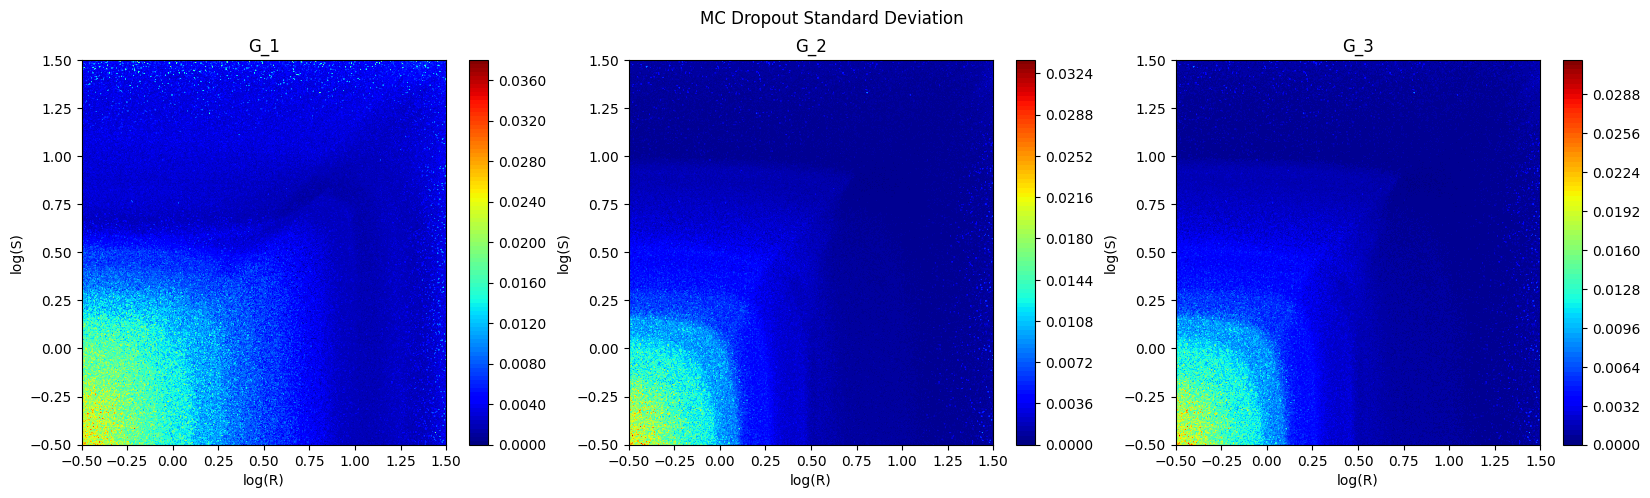

In [12]:

plot_heat_map_compare(x_grid, y_grid, target, mean_pred.T.reshape(3, dim, dim), bottom_title="MC Dropout Mean")

plot_heat_map_3D(x_grid, y_grid, variance_pred.T.reshape(3, dim, dim), title="MC Dropout Standard Deviation")